In [202]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pymongo import MongoClient
import glob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.preprocessing import Normalizer
import cPickle as pickle
import re
import requests
import json
import nltk.data
import operator
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import random
from gensim.summarization import summarize, keywords


In [5]:
client = MongoClient()
db = client.fletcher_all
col = db.reviews

In [6]:
def read_mongo(db, collection, query={}, host='localhost', port=27017, username=None, password=None, no_id=True):
    """ Read from Mongo and Store into DataFrame """

    # Connect to MongoDB
    # db = _connect_mongo(host=host, port=port, username=username, password=password, db=db)

    db = client.fletcher_all
    # Make a query to the specific DB and Collection
    cursor = db[collection].find(query)

    # Expand the cursor and construct the DataFrame
    df =  pd.DataFrame(list(cursor))

    # Delete the _id
    if no_id:
        del df['_id']

    return df

# Run basic tf-idf

In [7]:
df = read_mongo(db, 'reviews')
df.shape

(1818027, 6)

In [8]:
# Get rid of a few comments that are integers
df['comment_type'] = df.comments.apply(lambda x: type(x))
df = df[df.comment_type != int] 

In [243]:
# Using low max_df to try to drop some more common words
tfidf_vec_5 = TfidfVectorizer(stop_words='english', max_df=.3)

In [244]:
tfidf_comments_5 = tfidf_vec_5.fit_transform(df.comments)

In [154]:
pickle.dump( tfidf_vec_5, open( "tfidf_vec_5.p", "wb" ) ) #tfidf_vec_5 = TfidfVectorizer(stop_words='english', max_df=.4?)

In [8]:
fitted_tfidf = tfidf.fit_transform(df.comments) # this is per comment

# Framework for app

In [223]:
# Test urls

#url = 'https://www.airbnb.com/rooms/12908848?s=m99gI5lV'
#url = 'https://www.airbnb.com/rooms/13136171?s=m99gI5lV'
#url = 'https://www.airbnb.com/rooms/3545312?s=7Zfe9w2u'
url = 'https://www.airbnb.com/rooms/3283447?s=m99gI5lV'
#url = 'https://www.airbnb.com/rooms/3748756?s=m99gI5lV' 
#url = 'https://www.airbnb.com/rooms/834226?s=m99gI5lV' 
#url = 'https://www.airbnb.com/rooms/60365?s=dEpT32ks'


In [224]:
# Gets review texts
r = []
user_agent = {'User-agent': 'Mozilla/5.0'}
id_ = re.search(r"\d+",url).group(0)
api_request =  'https://api.airbnb.com/v2/reviews?client_id=3092nxybyb0otqw18e8nh5nty&locale=en-US&_limit=50&listing_id='+id_+'&role=all'
first_r = requests.get(api_request, headers = user_agent)
r.append(first_r)

In [225]:
# Can only get 50 at a time so this gets the rest, wooooot. 

count = first_r.json()['metadata']['reviews_count'] #Get the count
trips = count/50
offset = 0

if count > 50:
    while trips > 0:
        offset += 50
        api_request = 'https://api.airbnb.com/v2/reviews?client_id=3092nxybyb0otqw18e8nh5nty&locale=en-US&_offset='+str(offset)+'&_limit=50&listing_id='+id_+'&role=all'
        trips -= 1
        next_r = requests.get(api_request, headers = user_agent)
        r.append(next_r)

In [226]:
# Get an average for tf-idf transforms across all reviews for one room
comment_arrays = []
for obj in r:
    for review in obj.json()['reviews']:
        #comment = tfidf.transform([review['comments']])
        comment = tfidf_vec_5.transform([review['comments']])
        comment_arrays.append(comment.toarray()[0])
    
ave_tfidf = np.true_divide(np.sum(comment_arrays, axis=0), len(comment_arrays))

# Sentence ranker

In [227]:
top_terms = sorted(zip(tfidf_vec_5.get_feature_names(), ave_tfidf),key=lambda x: x[1], reverse=True)[:40]

In [228]:
for term in top_terms:
    print term

(u'mariel', 0.33607386622339458)
(u'alberto', 0.18125161141997082)
(u'hosts', 0.059056763544048672)
(u'loft', 0.039473012441858947)
(u'nice', 0.034718237962504991)
(u'space', 0.033648485284489091)
(u'san', 0.031947044230656071)
(u'amazing', 0.03019990163250897)
(u'experience', 0.028213533973120587)
(u'really', 0.026823356640430642)
(u'home', 0.026001576615465951)
(u'francisco', 0.025963830190599949)
(u'time', 0.025180858236553149)
(u'cool', 0.02408830408223088)
(u'sf', 0.02382527549479729)
(u'perfect', 0.023723259456650853)
(u'wonderful', 0.023364302332927842)
(u'recommend', 0.022664311355937525)
(u'comfortable', 0.022416792643580732)
(u'room', 0.021614135476048943)
(u'location', 0.021109697737151756)
(u'super', 0.020784806007304701)
(u'bed', 0.020569429314068972)
(u'like', 0.020442577963200613)
(u'husband', 0.019699027772443804)
(u'dogs', 0.019691304063344284)
(u'small', 0.019233589026832226)
(u'felt', 0.018363625776239633)
(u'thank', 0.018296220232041072)
(u'feel', 0.0180112160090692

In [229]:
# Create sentence tokens across all reviews for a room
reviews = ''
for thing in r:
    for review in thing.json()['reviews']:
        reviews += review['comments']
    
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
sent_tokens = tokenizer.tokenize(reviews)

In [230]:
def get_candidates(sent_tokens=sent_tokens, top_terms=top_terms, n_sents=5, cutoff=0):
    sent_scores = {}
    for sent in sent_tokens:
        sent_scores[sent] = 0
    for term, weight in top_terms[cutoff:]:
        for key, value in sent_scores.items():
            if term in key.lower():
                sent_scores[key] += weight
    sorted_sentences = sorted(sent_scores.items(), key=operator.itemgetter(1), reverse=True)
    return [x[0] for x in sorted_sentences[:n_sents]]


In [232]:
get_candidates(cutoff=0)

[u"The place is small but more than big enough for travel, and it's in a super convenient spot near the center of SF -- highly recommend!Mariel and Alberto were excellent hosts who made me feel very welcome.", u'We had a great time staying here on our quick trip to San Francisco, thank you again Mariel and Alberto!Amazing people, amazing loacation and an amazing home.', u'Not much els has to be said it was a fantastic experience and I would recommend staying with mariel and Alberto to anyoneThe hosts made us feel extremely welcomed.', u"Give the space and the hosts respect, and they will treat you like a good friend that they've known for years, Alberto and Mariel are what AirBnB hosts should be!the place was great and in a beautiful location.", u'Thank Mariel!A huge thanks to Mariel and Alberto for making us feel so welcome in their cool San Fran apartment.']

In [189]:
# Return list of sentences sorted by rank. Ranked by summed weight of terms according to averaged tf-idf vec
sent_scores = {}
for sent in sent_tokens:
    sent_scores[sent] = 0
for key, value in sent_scores.items():
    sent_n = 0
    for term, weight in top_terms[0:]:
        
        if term in key.lower():
            sent_scores[key] += weight
            sent_n += 1
    if sent_scores[key] > 0:
        sent_scores[key] = sent_scores[key]/sent_n
    
sorted_sentences = sorted(sent_scores.items(), key=operator.itemgetter(1), reverse=True)
[x[0] for x in sorted_sentences[:4]]

[u'Instructions to check in were clear and Lawrence kept communication short and sweet.',
 u'What else you need?Great communication by Lawrence for providing access.',
 u'Lawrence made accessing the apartment very easy.',
 u'Despite never meeting Lawrence, he managed to give a nice, warm welcome.']

In [191]:
sent_scores = {}
for sent in sent_tokens:
    sent_scores[sent] = 0
for key, value in sent_scores.items():
    sent_n = 0
    for term, weight in top_terms[15:]:
        if term in key.lower():
            sent_scores[key] += weight
            sent_n += 1
    if sent_scores[key] > 0:
        sent_scores[key] = sent_scores[key]/sent_n
    
sorted_sentences = sorted(sent_scores.items(), key=operator.itemgetter(1), reverse=True)
for sent in sorted_sentences[:4]:
    print sent
    print ''

(u'Great little apartment!', 0.032591997426019398)

(u'Everything was nice and clean and the place was very accommodating  to what I needed.', 0.032583962223130404)

(u'Despite never meeting Lawrence, he managed to give a nice, warm welcome.', 0.032583962223130404)

(u'It was nice having a code to get into the room.', 0.032583962223130404)



In [168]:
def neg_sents(sent_tokens=sent_tokens, top_terms=top_terms, n_sents=5, cutoff=10):
    neg_scores = {}
    for sent in sent_tokens:
        neg_scores[sent] = sia.polarity_scores(sent)

    neg_sentences = []
    for key, value in neg_scores.items():
        if value['compound'] < 0:
            neg_sentences.append(key)
    candidates = get_candidates(sent_tokens=neg_sentences, cutoff=cutoff)
    return candidates

In [233]:
neg_sents()

[u"I wasn't comfortable putting our family up here since it was their first time in the city.", u'Although there was nothing in the listing to explicitly state where the listing was located, I was disappointed that it was simply a room within a shared house rather than a unit within an apartment building.', u'Lastly, the photos give a misleading impression of light bathing the room: There is virtually no natural light available, especially since the shades on the glass doors to the 3-square-foot \u201cpatio\u201d cannot be kept open.', u'Also the ventilation in the room was very poor.', u'However, the ventilation in the private bathroom was poor which left stains on the walls and contributed to overall steaminess after a shower.']

In [234]:
# Uses same solution but only choosing from sentences with negative 'compound' sentiment

sia = SentimentIntensityAnalyzer()

neg_scores = {}
for sent in tokenizer.tokenize(reviews):
    neg_scores[sent] = sia.polarity_scores(sent)

neg_sentences = []
for key, value in neg_scores.items():
    if value['neg'] > 0:
        neg_sentences.append(key)
        

sent_scores = {}
for sent in neg_sentences:
    sent_scores[sent] = 0
    
for key, value in sent_scores.items():
    sent_n = 0
    for term, weight in top_terms[15:]:
        if term in key.lower():
            sent_scores[key] += weight
            sent_n += 1
    if sent_scores[key] > 0:
        sent_scores[key] = sent_scores[key]/sent_n
        
sorted_sentences = sorted(sent_scores.items(), key=operator.itemgetter(1), reverse=True)
for sent in sorted_sentences[:6]:
    print sent
    print ''

(u'The listing is very accurate so be mindful of the low ceilings especially (I am petite so it was perfect for me!).', 0.023723259456650853)

(u'Perfect for our very short stay, the loft was a few blocks from super cool shops, bars and restaurants.', 0.022254032731977777)

(u"If you want to live like a local, come to Mariel's place.This is in a perfect spot, between Hayes Valley and the lower Fillmore, but only 15 minutes from my client downtown.", 0.022082918709925733)

(u"Tiny space-  I would not recommend for anyone over 5'8 unless you dont mind hunching in the bedroom.", 0.021615958715351814)

(u'Room is quiet and cosy but the room ceiling is a little low for my height(182cm)Mariel and Alberto were great hosts.', 0.021614135476048943)

(u'The hallway ceiling in the back of the house leading to your room is quite low, but my friend and I didnt mind at all.', 0.021614135476048943)



In [1]:
sorted(neg_scores.items(), key=lambda val: val[1]["compound"], reverse=False)[:10]

NameError: name 'neg_scores' is not defined

In [32]:
sent_scores = {}
for sent in tokenizer.tokenize(reviews):
    sent_scores[sent] = 0
for term, weight in top_terms[20:]:
    for key, value in sent_scores.items():
        if term in key.lower():
            sent_scores[key] += weight
sorted_sentences = sorted(sent_scores.items(), key=operator.itemgetter(1), reverse=True)
for sent in sorted_sentences[:4]:
    print sent
    print ''

(u'Minuses: San Francisco real estate prices (most expensive rental market in the US) make themselves felt in the cost of the room, there is brown shag carpeting everywhere, and those big windows let in every noise from the street.', 0.062803268701669773)

(u"Overall a very enjoyable experience!I stayed at Ken's simple, bright and nice room for a week.", 0.061608781027208334)

(u'We didn\u2019t have the chance to talk a lot, but he was always welcoming and helpful.', 0.059785245583381934)

(u'Ken left bottled water and wine in the room, the bed is comfortable and the room is quite spacious.', 0.058554476591373888)



# Stop here...

In [42]:
sia = SentimentIntensityAnalyzer()

In [43]:
sia = SentimentIntensityAnalyzer()

neg_scores = {}
for sent in tokenizer.tokenize(reviews):
    neg_scores[sent] = sia.polarity_scores(sent)

In [94]:
sia = SentimentIntensityAnalyzer()

neg_scores = {}
for sent in tokenizer.tokenize(reviews):
    neg_scores[sent] = sia.polarity_scores(sent)

neg_sentences = []
for key, value in neg_scores.items():
    if value['compound'] > 0:
        neg_sentences.append(key)

In [85]:
sorted(neg_scores.items(), key=lambda val: val[1]["compound"], reverse=False)[:40]

[(u"I would stay again in a heartbeat.It was difficult to communicate with them, enter the apartment with their complicated locks, the bathroom was not clean, and they weren't very friendly.",
  {'compound': -0.7652, 'neg': 0.233, 'neu': 0.767, 'pos': 0.0}),
 (u"Just a testament of the kind of person Mariel is, but unfortunately we didn't get the chance to meet Alberto.",
  {'compound': -0.6381, 'neg': 0.235, 'neu': 0.765, 'pos': 0.0}),
 (u'I was very sad to leave and return to my very ordinary looking home!Great location close to everything.',
  {'compound': -0.6308, 'neg': 0.256, 'neu': 0.744, 'pos': 0.0}),
 (u"I visit SF a few times a year, and I've had some not so great lodging experiences, however this was not one of them.",
  {'compound': -0.6296, 'neg': 0.171, 'neu': 0.829, 'pos': 0.0}),
 (u"That's not the highlight though, sorry to disappoint.",
  {'compound': -0.6169, 'neg': 0.547, 'neu': 0.453, 'pos': 0.0}),
 (u'The only problem was there was no door in the room lacking priva

In [78]:
sorted(neg_scores, key=lambda key: neg_scores[key]["neg"], reverse=True)

[u"That's not the highlight though, sorry to disappoint.",
 u'I felt no pressure from them whatsoever.',
 u'I miss that place already!',
 u"That's probably my only complaint.",
 u'No issues what so ever.',
 u'The hall way to reach my bedroom was small, no doubt.',
 u'The only problem was there was no door in the room lacking privacy.',
 u'Mariel and Alberto are nothing short of amazing hosts!',
 u'Its a very cozy and convenient spot to crash.',
 u'I never felt like a stranger, it was more like I was visiting friends.',
 u'Mariel was incredibly hospitable and made sure they had no trouble getting settled in.',
 u'Also, parking in the area is rather difficult.',
 u'Warning to you tall ones out there as the ceiling is low in the room.',
 u'I was very sad to leave and return to my very ordinary looking home!Great location close to everything.',
 u"Small but I never felt like I didn't have enough room.",
 u'My parents had nothing but good things to say about the space!',
 u"Just a testament

In [73]:
neg_scores
       
#sorted(sent_scores.items(), key=operator.itemgetter(1), reverse=True)

{u'!Mariel & Alberto made us feel super welcome upon arriving.': {'compound': 0.8016,
  'neg': 0.0,
  'neu': 0.493,
  'pos': 0.507},
 u'!Mariel and her husband made us feel very welcome and the space is decorated beautifully.': {'compound': 0.8066,
  'neg': 0.0,
  'neu': 0.641,
  'pos': 0.359},
 u'!Mariel and her husband were absolutely charming and so were their dogs and home!': {'compound': 0.6885,
  'neg': 0.0,
  'neu': 0.735,
  'pos': 0.265},
 u'#belongsfI absolutely love this place!': {'compound': 0.6989,
  'neg': 0.0,
  'neu': 0.455,
  'pos': 0.545},
 u'(And I have great friends!)': {'compound': 0.6588,
  'neg': 0.0,
  'neu': 0.406,
  'pos': 0.594},
 u'+++ to great health, happiness, and love.': {'compound': 0.9169,
  'neg': 0.0,
  'neu': 0.252,
  'pos': 0.748},
 u':) Spent two nights here that may have been a bit strange for my hosts, but they were up front about it and me.': {'compound': 0.1531,
  'neg': 0.057,
  'neu': 0.861,
  'pos': 0.082},
 u":) The stay at Mariel & Alberto

In [264]:
results

u"The place is small but more than big enough for travel, and it's in a super convenient spot near the center of SF -- highly recommend!Mariel and Alberto were excellent hosts who made me feel very welcome.\nI would definitely consider to stay with them again if I ever need an Airbnb in SF in the future!The hosts were exceptionally welcoming, and the space is very cool, well designed, and in a great part of SF.\nWe had a great time staying here on our quick trip to San Francisco, thank you again Mariel and Alberto!Amazing people, amazing loacation and an amazing home.\nNot much els has to be said it was a fantastic experience and I would recommend staying with mariel and Alberto to anyoneThe hosts made us feel extremely welcomed.\nGive the space and the hosts respect, and they will treat you like a good friend that they've known for years, Alberto and Mariel are what AirBnB hosts should be!the place was great and in a beautiful location."

In [84]:
temp = pd.DataFrame(fitted_tfidf.toarray(), columns=tfidf.get_feature_names())

# LSA

In [245]:
# 20 topics
lsa_model = TruncatedSVD(20)

In [246]:
#
tfidf_lsa = lsa_model.fit_transform(tfidf_comments_5)

In [247]:
tfidf_lsa = Normalizer(copy=False).fit_transform(tfidf_lsa)

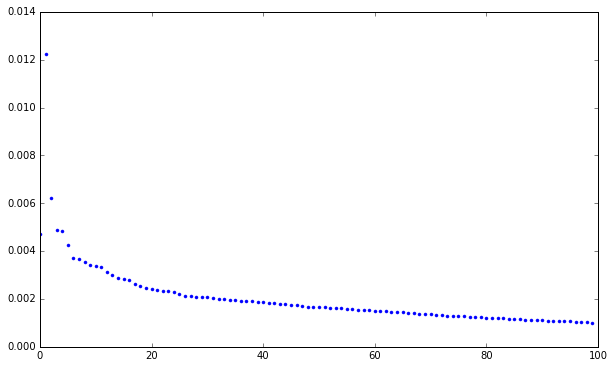

In [15]:
# Plotting the eigens
plt.figure(figsize=(10,6))
plt.plot(range(len(lsa_model.explained_variance_ratio_)), lsa_model.explained_variance_ratio_, '.');

## Topic by term dataframe

In [250]:
topic_df = pd.DataFrame(lsa_model.components_, columns=tfidf_vec_5.get_feature_names())

In [259]:
# Looking at top terms in each topic
topic_df.iloc[17,:].sort_values(ascending=False)[:20]

friendly         0.382574
helpful          0.280812
definitely       0.280117
super            0.254141
home             0.193339
perfect          0.131230
time             0.125468
good             0.119059
hosts            0.102923
welcoming        0.101151
described        0.094625
exactly          0.085618
house            0.076783
accommodating    0.070887
felt             0.068336
like             0.065317
feel             0.058842
come             0.049525
easy             0.046712
awesome          0.045464
Name: 17, dtype: float64

In [36]:
# See term importance by topic(numerical)
topic_df.loc[:,'john'].sort_values(ascending=False)[:20]

94    0.140804
97    0.090368
99    0.050783
81    0.048013
92    0.045764
93    0.042476
79    0.038951
74    0.037089
73    0.036857
83    0.030670
84    0.027182
78    0.026381
69    0.024264
86    0.022539
39    0.016842
61    0.016703
0     0.015752
98    0.012828
34    0.011688
29    0.011474
Name: john, dtype: float64